In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings #Latex Syntax for Plotting
using ITensors
using Plots

import ITensors: op # Allows overloading of ITensors.op

$$ H = -t\sum_{\sigma = \uparrow, \downarrow} \sum_{j = 1}^{N - 1}( c^{\dagger}_{j, \sigma}c_{j+1, \sigma} + h.c.)+U \sum_{j = 1}^{N} n_{j \uparrow} n_{j \downarrow}$$

**Exact Diagonalization Functions:**

In [2]:
C_up = [0 1 0 0; 0 0 0 0; 0 0 0 1; 0 0 0 0] #C_↑
Cdag_up = adjoint(C_up) #C†_↑
C_down = [0 0 1 0; 0 0 0 -1; 0 0 0 0; 0 0 0 0] #C_↓
Cdag_down = adjoint(C_down) #C†_↓
n_up = Cdag_up*C_up #n_↑
n_down = Cdag_down*C_down #n_↓
# P = (-1.0 + 0im)^(n_up + n_down)
P = [1 0 0 0; 0 -1 0 0; 0 0 -1 0; 0 0 0 1] #Parity Operator

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

In [3]:
function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity
    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [4]:
# Enlarge_Matrix_i_Matrix_j(2,3,4, Cdag_up*P, C_up) == kron(P*P, Cdag_up*P, C_up, P*P) #Test

In [5]:
function Build_Hamiltonian(t,U, N)

    H = zeros(4^N, 4^N) #Local Hilbert Space Dimension = 4
    
    for k=1:N-1
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_up*P, C_up) #C†_j,↑*#C_j+1,↑
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_down*P, C_down) #C†_j,↓*#C_j+1,↓
    end
    H += adjoint(H) #h.c.

    for k=1:N
        H += U*Enlarge_Matrix_site_j(k, N, n_up*n_down) #n_↑*n_↓
    end

    return H
end

function Time_Evolution_Operator(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

function double_occupancy_ED(psi)
    N = log2(length(psi))/2

    d = 0
    for j in 1:N
        Op = Enlarge_Matrix_site_j(j, N, n_up*n_down)
        d += adjoint(psi)*Op*psi
    end
    
   return d/N     
end

function staggered_magnetization_ED(psi)
    N = log2(length(psi))/2
    
    ms = 0
    for j in 1:N
        Nup = Enlarge_Matrix_site_j(j, N, n_up)
        Ndn = Enlarge_Matrix_site_j(j, N, n_down)
        ms += (-1)^(j)*(adjoint(psi)*Nup*psi - adjoint(psi)*Ndn*psi)
    end
    
    return ms/(2*N) 
end

staggered_magnetization_ED (generic function with 1 method)

**ITensor Functions:**

In [6]:
#Definitions JJ:

op(::OpName"PCup",::SiteType"Electron") = [0 1 0 0
                                           0 0 0 0
                                           0 0 0 -1
                                           0 0 0 0]; 

op(::OpName"PCdn",::SiteType"Electron") = [0 0 1 0
                                           0 0 0 1
                                           0 0 0 0
                                           0 0 0 0];

op(::OpName"CdagupP",::SiteType"Electron") = [0 0 0 0
                                              1 0 0 0
                                              0 0 0 0
                                              0 0 -1 0]; 

op(::OpName"CdagdnP",::SiteType"Electron") = [0 0 0 0
                                              0 0 0 0
                                              1 0 0 0
                                              0 1 0 0];

# New version of creation and annihilation operators to use OpSum

op(::OpName"CupNew",::SiteType"Electron") = [0 1 0 0
                                             0 0 0 0
                                             0 0 0 1
                                             0 0 0 0]; 

op(::OpName"CdnNew",::SiteType"Electron") = [0 0 1 0
                                             0 0 0 -1
                                             0 0 0 0
                                             0 0 0 0];

op(::OpName"CdagupNew",::SiteType"Electron") = [0 0 0 0
                                                1 0 0 0
                                                0 0 0 0
                                                0 0 1 0]; 

op(::OpName"CdagdnNew",::SiteType"Electron") = [0 0 0 0
                                                0 0 0 0
                                                1 0 0 0
                                                0 -1 0 0];


In [7]:
function Create_H_MPO(t,U, N, sites = []) 

    if length(sites) == 0
        sites = siteinds("Electron",N)    
    end
    
    os = OpSum() 
    for j=1:N-1 

        #JJ Code: This version is working
        
        # os += -t,"CdagdnP",j,"CdnNew",j+1
        # os += -t,"PCdn",j,"CdagdnNew",j+1
        # os += -t,"CdagupP",j,"CupNew",j+1
        # os += -t,"PCup",j,"CdagupNew",j+1   

        #What if we remove New because they are the same? This version is not working
        # os += -t,"CdagdnP",j,"Cdn",j+1
        # os += -t,"PCdn",j,"Cdagdn",j+1
        # os += -t,"CdagupP",j,"Cup",j+1
        # os += -t,"PCup",j,"Cdagup",j+1               

        #Using default operators Attempt: This version is working

        os += -t,"Cdagup",j,"Cup",j+1 
        os += -t,"Cdagup",j+1,"Cup",j
        os += -t,"Cdagdn",j,"Cdn",j+1 
        os += -t,"Cdagdn",j+1,"Cdn",j

        #Our F is the parity operator, what if we write this? This version is not working
        # os += -t,"Cdagdn * F",j,"Cdn",j+1
        # os += -t,"F * Cdn",j,"Cdagdn",j+1
        # os += -t,"Cdagup * F",j,"Cup",j+1
        # os += -t,"F * Cup",j,"Cdagup",j+1      
    
    end 

    for j=1:N
        os += U,"Nup * Ndn",j
    end
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function double_occupancy_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    d = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        d += inner(psi, apply(Nup, apply(Ndn,psi)))
    end
    
    return d/N 
end

function staggered_magnetization_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    ms = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        ms += (-1)^(j)*(inner(psi, apply(Nup,psi)) - inner(psi, apply(Ndn,psi)))
    end
    
    return ms/(2*N) 
end

function TEBD_Values(t, Psi_0, J, U, maxdim = 40, output = false)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Main Function

    N = length(Psi_0)
    cutoff = 1E-8
    dt = 0.01
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("Cdagup", s1)*op("Cup", s2) -J*op("Cdagup", s2)*op("Cup", s1)
        hj += -J*op("Cdagdn", s1)*op("Cdn", s2) -J*op("Cdagdn", s2)*op("Cdn", s1)


        # hj = -J*op("Cdagup * F", s1)*op("Cup", s2) -J*op("Cup * F", s1)*op("Cdagup", s2) #It is working
        # hj += -J*op("Cdagdn * F", s1)*op("Cdn", s2) -J*op("Cdn * F", s1)op("Cdagdn", s2)     
        
        hj += U*op("Nup * Ndn", s1)*op("Id", s2)

        if j == N-1
            hj += U*op("Nup * Ndn", s2)*op("Id", s1)
        end
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    d_values = [double_occupancy_TN(Psi_0)] 
    ms_values = [staggered_magnetization_TN(Psi_0)]
    
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)  #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
        normalize!(Psi_t)

        append!(Times, time)
        append!(d_values, double_occupancy_TN(Psi_t).re)
        append!(ms_values, staggered_magnetization_TN(Psi_t).re)

        if output == true
            println("Values for t = "*string(time)*" calculated.")
        end
    end
    
    return d_values, ms_values, Times
end

TEBD_Values (generic function with 3 methods)

In [42]:
N = 6
t = 1
U = 4
tf = 4

4

In [43]:
nsweeps = 10
maxdim = [500] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

1-element Vector{Float64}:
 1.0e-10

In [44]:
H, sites = Create_H_MPO(t,U, N) 
DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(H,randomMPS(sites); nsweeps, maxdim, cutoff, observer = DMRG_observer) 

After sweep 1 energy=-3.9432905952797315  maxlinkdim=16 maxerr=1.60E-16 time=0.029
After sweep 2 energy=-4.352067450696445  maxlinkdim=60 maxerr=9.79E-11 time=0.248
After sweep 3 energy=-4.416270137097889  maxlinkdim=59 maxerr=9.98E-11 time=0.242
After sweep 4 energy=-4.421792735417886  maxlinkdim=55 maxerr=8.88E-11 time=0.216
After sweep 5 energy=-4.422066508204508  maxlinkdim=46 maxerr=8.28E-11 time=0.196
After sweep 6 energy=-4.422071098110528  maxlinkdim=27 maxerr=9.61E-11 time=0.150
After sweep 7 energy=-4.4220711471524945  maxlinkdim=25 maxerr=6.14E-11 time=0.097
After sweep 8 energy=-4.422071147528591  maxlinkdim=25 maxerr=3.29E-11 time=0.088
After sweep 9 energy=-4.422071147530274  maxlinkdim=25 maxerr=3.19E-11 time=0.083
After sweep 10 energy=-4.422071147530257  maxlinkdim=25 maxerr=3.19E-11 time=0.080


(-4.422071147530257, MPS
[1] ((dim=4|id=618|"Link,l=1"), (dim=4|id=698|"Electron,Site,n=1"))
[2] ((dim=16|id=320|"Link,l=2"), (dim=4|id=757|"Electron,Site,n=2"), (dim=4|id=618|"Link,l=1"))
[3] ((dim=4|id=605|"Electron,Site,n=3"), (dim=25|id=993|"Link,l=3"), (dim=16|id=320|"Link,l=2"))
[4] ((dim=4|id=498|"Electron,Site,n=4"), (dim=16|id=373|"Link,l=4"), (dim=25|id=993|"Link,l=3"))
[5] ((dim=4|id=322|"Electron,Site,n=5"), (dim=4|id=942|"Link,l=5"), (dim=16|id=373|"Link,l=4"))
[6] ((dim=4|id=627|"Electron,Site,n=6"), (dim=4|id=942|"Link,l=5"))
)

In [45]:
# Matrix(op("Cdagup", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("PCdn", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cup", sites[1]),sites[1]',sites[1]) == Matrix(op("PCup", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Cdag_up*P

In [46]:
H_ED = Build_Hamiltonian(t,U, N)
values, vectors = eigen(H_ED)
Psi_0 = vectors[:,1]
values

4096-element Vector{Float64}:
 -4.422071147758748
 -4.063601640902709
 -4.063601640902709
 -4.063601640902709
 -4.063311949299884
 -4.063311949299884
 -3.9843589627621956
 -3.9843589627621956
 -3.7156715880653834
 -3.7156715880653834
 -3.6876257811430326
 -3.687625781143029
 -3.687625781143029
  ⋮
 20.130534197834915
 20.445041867912625
 20.445041867912625
 20.460446370594543
 20.872336983871616
 21.246979603717467
 21.246979603717467
 21.263081178266564
 21.549102862741815
 21.80193773580483
 21.801937735804838
 24.0

In [47]:
double_occupancy_ED(Psi_0), double_occupancy_TN(psi_ground_state)

(0.0367583620801699, 0.03675836201332052)

In [48]:
staggered_magnetization_ED(Psi_0), staggered_magnetization_TN(psi_ground_state)

(5.088522196198634e-17, 2.039383481533541e-9)

In [49]:
Initial_State = []
for i=1:N

    if i%2==0
        append!(Initial_State, ["Up"])
    else
        append!(Initial_State, ["Dn"])
    end
end

In [50]:
Initial_State

6-element Vector{Any}:
 "Dn"
 "Up"
 "Dn"
 "Up"
 "Dn"
 "Up"

In [51]:
H, sites = Create_H_MPO(t,U, N) 
Initial_MPS = MPS(sites, Initial_State)
normalize!(Initial_MPS)

MPS
[1] ((dim=4|id=574|"Electron,Site,n=1"), (dim=1|id=541|"Link,l=1"))
[2] ((dim=1|id=541|"Link,l=1"), (dim=4|id=713|"Electron,Site,n=2"), (dim=1|id=746|"Link,l=2"))
[3] ((dim=1|id=746|"Link,l=2"), (dim=4|id=33|"Electron,Site,n=3"), (dim=1|id=939|"Link,l=3"))
[4] ((dim=1|id=939|"Link,l=3"), (dim=4|id=490|"Electron,Site,n=4"), (dim=1|id=455|"Link,l=4"))
[5] ((dim=1|id=455|"Link,l=4"), (dim=4|id=336|"Electron,Site,n=5"), (dim=1|id=218|"Link,l=5"))
[6] ((dim=1|id=218|"Link,l=5"), (dim=4|id=569|"Electron,Site,n=6"))


In [52]:
d_values_TN, ms_values_TN, times_TN = TEBD_Values(tf, Initial_MPS, t, U)

([0.0, 0.00016658530366863312, 0.0006656535548957258, 0.001494970344011426, 0.0026508236520213055, 0.004128041958355612, 0.005920019473811666, 0.008018748359802281, 0.010414857754662754, 0.013097659389623123  …  0.07760754693819695, 0.07935898511100567, 0.08113842937846255, 0.08293720765232532, 0.08474658016624016, 0.0865577799067308, 0.08836205318311102, 0.0901507001461293, 0.09191511505982584, 0.09364682613201823], [0.5, 0.4998334146956653, 0.4993341966082117, 0.4985039652188607, 0.49734543954125954, 0.4958624095792213, 0.49405971975628366, 0.49194324774909354, 0.48951987884067494, 0.4867974759343859  …  -0.0071150461372711015, -0.006669649857626553, -0.006212730224224157, -0.005742868634171584, -0.005258684028870669, -0.004758838425916068, -0.004242042173516841, -0.00370705890339329, -0.0031527101739102412, -0.0025778798093079223], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0])

In [53]:
up = [0.0; 1.0; 0.0; 0.0]
dn = [0.0; 0.0; 1.0; 0.0]

Initial_vector = kron(dn,up,dn,up,dn,up)
# Initial_vector = kron(dn,up,dn,up)

4096-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [54]:
dt = 0.01

U_Operator = Time_Evolution_Operator(dt, H_ED)

d_values_ED = [double_occupancy_ED(Initial_vector)] 
ms_values_ED = [staggered_magnetization_ED(Initial_vector)]
times_ED = [0.0]

Psi_t = Initial_vector

for k=1:Integer(tf/dt)
    
    Psi_t = U_Operator*Psi_t
    append!(d_values_ED, double_occupancy_ED(Psi_t))
    append!(ms_values_ED, staggered_magnetization_ED(Psi_t))
    append!(times_ED, dt*k)
end

In [55]:
d_values_ED, ms_values_ED, times_ED

([0.0, 0.00016660001276889603, 0.0006656008169263521, 0.0014946092999327547, 0.0026496522109273886, 0.004125198962206446, 0.005914193344894944, 0.008008093954188738, 0.010396923063595997, 0.013069323633521498  …  0.06518207330555831, 0.0632804540275445, 0.06145962936572946, 0.059726500334152645, 0.05808778318170834, 0.05654997651309721, 0.055119328379957144, 0.053801803525364685, 0.052603050970532333, 0.05152837213700586], [0.5, 0.49983336999523037, 0.49933391969480184, 0.4985029665250722, 0.49734270048721757, 0.49585617562172946, 0.4940472981157769, 0.4919208111101103, 0.48948227627783175, 0.48673805226253014  …  0.02183635973830419, 0.022047988106431993, 0.0222478398551786, 0.022435995984788445, 0.022612561786164106, 0.022777666551671114, 0.02293146321796549, 0.023074127941258068, 0.023205859605634555, 0.02332687926526141], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0])

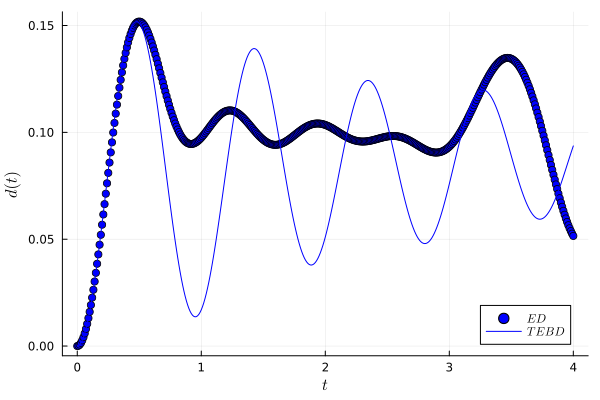

In [56]:
scatter(times_ED, d_values_ED, label= L"ED", color = "blue")
plot!(times_TN, d_values_TN, label= L"TEBD", color = "blue")
xlabel!(L"t")
ylabel!(L"d(t)")

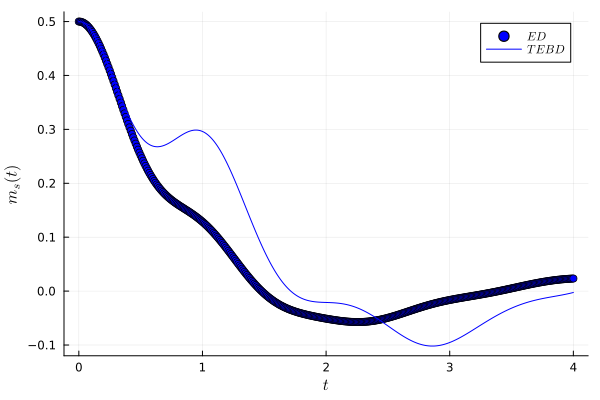

In [57]:
scatter(times_ED, ms_values_ED, label= L"ED", color = "blue")
plot!(times_TN, ms_values_TN, label= L"TEBD", color = "blue")
xlabel!(L"t")
ylabel!(L"m_{s}(t)")